# Run Any Kind of Logistic Regression (Binomial, Multinomial, etc.)

### Authors: Calvin Howard.

#### Last updated: March 16, 2024

Use this to run/test a statistical model on a spreadsheet.

Notes:
- To best use this notebook, you should be familar with GLM design and Contrast Matrix design. See this webpage to get started:
[FSL's GLM page](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM)

# 00 - Import CSV with All Data
**The CSV is expected to be in this format**
- ID and absolute paths to niftis are critical
```
+-----+----------------------------+--------------+--------------+--------------+
| ID  | Nifti_File_Path            | Covariate_1  | Covariate_2  | Covariate_3  |
+-----+----------------------------+--------------+--------------+--------------+
| 1   | /path/to/file1.nii.gz      | 0.5          | 1.2          | 3.4          |
| 2   | /path/to/file2.nii.gz      | 0.7          | 1.4          | 3.1          |
| 3   | /path/to/file3.nii.gz      | 0.6          | 1.5          | 3.5          |
| 4   | /path/to/file4.nii.gz      | 0.9          | 1.1          | 3.2          |
| ... | ...                        | ...          | ...          | ...          |
+-----+----------------------------+--------------+--------------+--------------+
```

Prep Output Directory

In [ ]:
# Specify where you want to save your results to
out_dir = '/Users/cu135/Dropbox (Partners HealthCare)/studies/collaborations/barotono_disease_classification'

Import Data

In [ ]:
# Specify the path to your CSV file containing NIFTI paths
input_csv_path = '/Users/cu135/Dropbox (Partners HealthCare)/studies/collaborations/barotono_disease_classification/wmap_unthresh_Spatial_Rs.csv'
sheet = None

In [ ]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=out_dir, sheet=sheet)
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()

# 01 - Preprocess Your Data

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [ ]:
data_df.columns

In [ ]:
drop_list = ['Unnamed__11', 'Unnamed__12']

In [ ]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
display(data_df)

Drop Columns which Have NaNs

In [ ]:
data_df.dropna(inplace=True, axis=1)
data_df

**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

In [ ]:
data_df.columns

Set the parameters for dropping rows

In [ ]:
column = 'City'  # The column you'd like to evaluate
condition = 'not'  # The condition to check ('equal', 'above', 'below', 'not')
value = 'Toronto' # The value to drop if found

In [ ]:
data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
display(data_df)

**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [ ]:
# Remove anything you don't want to standardize
cols_not_to_standardize = ['cat_dx'] # ['Z_Scored_Percent_Cognitive_Improvement_By_Origin_Group', 'Z_Scored_Subiculum_T_By_Origin_Group_'] #['Age']

In [ ]:
data_df = cal_palm.standardize_columns(cols_not_to_standardize)
data_df

In [ ]:
# for col in data_df.columns:
#     if 'CSF' and 'eh' not in col:
#         data_df[col] = data_df[col] * -1

# 02 - Define Your Formula

This is the formula relating outcome to predictors, and takes the form:
- y = B0 + B1 + B2 + B3 + . . . BN

It is defined using the columns of your dataframe instead of the variables above:
- 'Apples_Picked ~ hours_worked + owns_apple_picking_machine'

____
**Normal Logistic**
- Assesses the impact of multiple predictors on an outcome.
- formula = 'Binary Outcome ~ Predictor1 + Predictor2'

**Multiple Logistic**
- Assesses the impact of predictor on an outcome.
- formula = 'Ordinal Outcome ~ Predictor1 + Predictor2'

____
Use the printout below to design your formula. 
- Left of the "~" symbol is the thing to be predicted. 
- Right of the "~" symbol are the predictors. 
- ":" indicates an interaction between two things. 
- "*" indicates and interactions AND it accounts for the simple effects too. 
- "+" indicates that you want to add another predictor. 

In [ ]:
data_df.columns

In [ ]:
formula = "cat_dx ~  SV + BV + CN + PNFA + CBS + PSP + PPMI + AD"

# 02 - Visualize Your Design Matrix

This is the explanatory variable half of your regression formula
_______________________________________________________
Create Design Matrix: Use the create_design_matrix method. You can provide a list of formula variables which correspond to column names in your dataframe.

- design_matrix = palm.create_design_matrix(formula_vars=["var1", "var2", "var1*var2"])
- To include interaction terms, use * between variables, like "var1*var2".
- By default, an intercept will be added unless you set intercept=False
- **don't explicitly add the 'intercept' column. I'll do it for you.**

In [ ]:
# Define the design matrix
outcome_matrix, design_matrix = cal_palm.define_design_matrix(formula, data_df)
design_matrix

# 03 - Visualize Your Dependent Variable

I have generated this for you based on the formula you provided

In [ ]:
outcome_matrix

# 04 - Generate Contrasts

Generate a Contrast Matrix
- This is different from the contrast matrices used in cell-means regressions such as in PALM, but it is much more powerful. 



For more information on contrast matrices, please refer to this: https://cran.r-project.org/web/packages/codingMatrices/vignettes/codingMatrices.pdf

Generally, these drastically effect the results of ANOVA. However, they are mereley a nuisance for a regression.
In essence, they assess the coefficients of a given

________________________________________________________________
A coding matrix (a contrast matrix if it sums to zero) is simply a way of defining what coefficients to evaluate and how to evaluate them. 
If a coefficient is set to 1 and everything else is set to zero, we are taking the mean of the coefficient's means and assessing if they significantly
deviate from zero--IE we are checking if it had a significant impact on the ability to predict the depdendent variable.
If a coefficient is set to 1, another is -1, and others are 0, we are assessing how the means of the two coefficients deviate from eachother. 
If several coefficients are 1 and several others are -1, we are assessing how the group-level means of the two coefficients deviate from eachother.
If a group of coefficients are 1, a group is -1, and a group is 0, we are only assessing how the groups +1 and -1 have differing means. 

1: This value indicates that the corresponding variable's coefficient in the model is included in the contrast. It means you are interested in estimating the effect of that variable.

0: This value indicates that the corresponding variable's coefficient in the model is not included in the contrast. It means you are not interested in estimating the effect of that variable.

-1: This value indicates that the corresponding variable's coefficient in the model is included in the contrast, but with an opposite sign. It means you are interested in estimating the negative effect of that variable.

----------------------------------------------------------------
The contrast matrix is typically a matrix with dimensions (number of contrasts) x (number of regression coefficients). Each row of the contrast matrix represents a contrast or comparison you want to test.

For example, let's say you have the following regression coefficients in your model:

Intercept, Age, connectivity, Age_interaction_connectivity
A contrast matric has dimensions of [n_predictors, n_experiments] where each experiment is a contrast

If you want to test the hypothesis that the effect of Age is significant, you can set up a contrast matrix with a row that specifies this contrast (actually an averaging vector):
```
[0,1,0,0]. This is an averaging vector because it sums to 1
```
This contrast will test the coefficient corresponding to the Age variable against zero.


If you want to test the hypothesis that the effect of Age is different from the effect of connectivity, you can set up a contrast matrix with two rows:
```
[0,1,−1,0]. This is a contrast because it sums to 0
```

Thus, if you want to see if any given effect is significant compared to the intercept (average), you can use the following contrast matrix:
```
[1,0,0,0]
[-1,1,0,0]
[-1,0,1,0]
[-1,0,0,1] actually a coding matrix of averaging vectors
```

The first row tests the coefficient for Age against zero, and the second row tests the coefficient for connectivity against zero. The difference between the two coefficients can then be assessed.
_____
You can define any number of contrasts in the contrast matrix to test different hypotheses or comparisons of interest in your regression analysis.

It's important to note that the specific contrasts you choose depend on your research questions and hypotheses. You should carefully consider the comparisons you want to make and design the contrast matrix accordingly.

- Examples:
    - [Two Sample T-Test](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM#Two-Group_Difference_.28Two-Sample_Unpaired_T-Test.29)
    - [One Sample with Covariate](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM#Single-Group_Average_with_Additional_Covariate)

In [ ]:
contrast_matrix = cal_palm.generate_basic_contrast_matrix(design_matrix)


Edit Contrast Matrix Here
- The generic contrast matrix will simply check if your Betas are significantly different from the intercept (average)

In [ ]:
# contrast_matrix = [
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, -1, 1, 0, 0, 0, 0, 0, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, 1, -1, 1, -1, 1],
# ]

Finalize Contrast Matrix

In [ ]:
contrast_matrix_df = cal_palm.finalize_contrast_matrix(design_matrix=design_matrix, 
                                                    contrast_matrix=contrast_matrix) 
contrast_matrix_df

# 06 - Run the Regression

Regression Results Are Displayed Below

Option A) Logistic Regression between A Binary Outcome

In [ ]:
import statsmodels.api as sm
# Fit the regression model
model = sm.Logit(outcome_matrix, design_matrix)
results = model.fit()
print(results.summary2())

Option B) Multinomial Logistic Regression

In [34]:
import statsmodels.api as sm
# Fit the regression model
model = sm.MNLogit(outcome_matrix, design_matrix)
results = model.fit()
print(results.summary2())

Optimization terminated successfully.
         Current function value: 0.817858
         Iterations 10
                         Results: MNLogit
Model:              MNLogit          Pseudo R-squared: 0.516      
Dependent Variable: cat_dx           AIC:              1606.3239  
Date:               2024-03-19 12:22 BIC:              1909.2238  
No. Observations:   905              Log-Likelihood:   -740.16    
Df Model:           56               LL-Null:          -1529.4    
Df Residuals:       842              LLR p-value:      2.6756e-293
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     10.0000                                       
-----------------------------------------------------------------
 cat_dx = 0   Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-----------------------------------------------------------------
Intercept     5.8756    2.0920   2.8086  0.0050   1.7753   9.9759
       SV    -3.6119    1.4720  -2.4538  0.0141  -6.496

Get Classification Accuracy

In [57]:
import numpy as np
predictions = np.asarray(results.predict()).argmax(1) + 1
observed = data_df['cat_dx'].to_list()

from sklearn.metrics import accuracy_score, confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(observed, predictions)

# Extract TP, TN, FP, FN from confusion matrix
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]

# Calculate accuracy
accuracy = accuracy_score(observed, predictions)

# Calculate sensitivity
sensitivity = TP / (TP + FN)

# Calculate specificity
specificity = TN / (TN + FP)

# Calculate reliability
reliability = TP / (TP + FP)

# Print or use the metrics as needed
print("Accuracy:", accuracy)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Reliability:", reliability)


Accuracy: 0.6729281767955801
Sensitivity: 0.9428571428571428
Specificity: 0.9166666666666666
Reliability: 0.9166666666666666


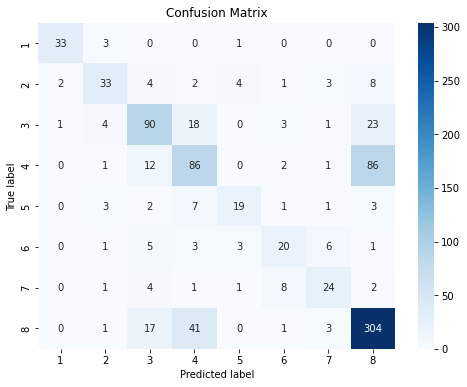

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(observed, predictions)

# Get unique labels
labels = np.unique(observed)

# Create a heatmap of the confusion matrix with actual labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.show()



Visualize the Regression as a Forest Plot
- This will probably look poor if you ran a regression without standardizing your data. 

In [ ]:
from calvin_utils.statistical_utils.statistical_measurements import ForestPlot
forest = ForestPlot(model=results, sig_digits=2, out_dir=out_dir, table=False)
forest.run()

Visualize The Model's Fit

In [ ]:
from calvin_utils.statistical_utils.statistical_measurements import model_diagnostics
model_diagnostics(results)

Visualize the Partial Regression Plots

In [ ]:
from calvin_utils.statistical_utils.statistical_measurements import PartialRegressionPlot
partial_plot = PartialRegressionPlot(model=results, design_matrix=design_matrix, out_dir=out_dir, palette='Reds')
partial_plot = partial_plot.run()

# 07 - Run the Contrasts

Contrast Results Are Displayed Below

In [ ]:
contrast_matrix_df

In [ ]:
contrast_results = results.t_test(contrast_matrix_df)
print(contrast_results.summary())

# 08 - Compare the Coefficient Between 2 Groups

In [ ]:
groups_column = 'Age_Group'

In [ ]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import RegressionAnalysis
regression_test = RegressionAnalysis(outcome_df=outcome_matrix, design_df=design_matrix, groups_df=data_df[[groups_column]], N=10000, metric='similarity', two_tail=False, out_dir=out_dir)
regression_test.run()

# 09 - Compare Distribution of T Values Between Groups

In [ ]:
data_df.columns

In [ ]:
plot_together=False
groups_column = 'Age_Group'

In [ ]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import BootstrappedRegressionAnalysis

# Create an instance of BootstrappedRegressionAnalysis
bootstrapped_regression_test = BootstrappedRegressionAnalysis(outcome_df=outcome_matrix, design_df=design_matrix, groups_df=data_df[[groups_column]], N=10000, out_dir=out_dir, plot_together=plot_together)

# Run the bootstrapped regression analysis
df1 = bootstrapped_regression_test.run()

# 10 - Predict Another Dataframe
- Can use this to predict data from a second group, such as the 'other_df' defined in "Step 01, Drop Rows Based on Value of a Column"

In [ ]:
import numpy as np
from scipy.stats import f

def calculate_ssr(observations, predictions):
    """
    Calculate the regression sum of squares.
    This is the sum of squared deviations, with deviation being Y_hat_i - Y_bar
    
    SSR is a measure used to quantify the variance in the observed data that is not explained by the model. 
    It is calculated as the sum of the squares of the differences between the observed values and the model's predictions. 
    The more the 'mean' predicts 
    A lower SSR indicates a better model fit, meaning the model's predictions are closer to the actual observations.
    
    SSR = Σ(y_hat - y_bar)^2 
    
    Parameters:
    - observations (array-like): The actual observed outcomes.
    - predictions (array-like): The outcomes predicted by the model.
    
    Returns:
    - float: The calculated SSR.
    """
    y_hat = observations
    y_bar = np.mean(predictions)
    ssr = np.sum((y_hat - y_bar) ** 2)
    return ssr

def calculate_sse(observations, predictions):
    """
    Calculate the sum of squares due to error (SSE).
    
    SSE is a measure of the total deviation of the response values from the fit to the response values. 
    It is calculated as the sum of the squares of the differences between the predicted values and the observed values. 
    A lower SSE indicates a model that more accurately fits the data.
    
    SSE = Σ(y - y_hat)^2
    
    Parameters:
    - observations (array-like): The actual observed outcomes.
    - predictions (array-like): The outcomes predicted by the model.
    
    Returns:
    - float: The calculated SSE.
    """
    y = observations
    y_hat = predictions
    sse = np.sum((y - y_hat) ** 2)
    return sse

def calculate_ssto(observations):
    """
    Calculate the total sum of squares (SSTO).
    
    SSTO is a measure of the total variance in the observed data and is used as a comparative tool for model evaluation. 
    It is calculated as the sum of the squares of the differences between the observed values and their overall mean. 
    SSTO is used in the denominator of the coefficient of determination, R^2, which assesses the fit of the model.
    
    SSTO = Σ(y - y_bar)^2
    
    Parameters:
    - observations (array-like): The actual observed outcomes.
    
    Returns:
    - float: The calculated SSTO.
    """
    y = observations
    y_bar = np.mean(y)
    ssto = np.sum((y - y_bar) ** 2)
    return ssto


def calculate_msr(ssr, num_regressors):
    """
    Calculate the mean square due to regression (MSR).
    
    MSR is a measure of the variation explained by the independent variables in the model. It is calculated as the 
    sum of squared residuals (SSR) divided by the degrees of freedom, which is the number of independent variables (regressors) minus one.
    A higher MSR indicates that the model explains a greater amount of variation in the outcome variable.
    
    MSR = SSR / (number of regressors - 1)
    
    Parameters:
    - ssr (float): The sum of squared residuals from the regression model.
    - num_regressors (int): The number of independent variables in the model.
    
    Returns:
    - float: The calculated MSR.
    """
    return ssr / (num_regressors - 1)

def calculate_mse(sse, num_regressors, num_observations):
    """
    Calculate the mean square error (MSE).
    
    MSE is a measure of the average of the squares of the errors, that is, the average squared difference between the observed actual outcomes and the outcomes predicted by the model. It is calculated as the sum of squared errors (SSE) divided by the degrees of freedom, which is the number of observations minus the number of regressors.
    A lower MSE indicates a better fit of the model to the data.
    
    MSE = SSE / (number of observations - number of regressors)
    
    Parameters:
    - sse (float): The sum of squared errors from the regression model.
    - num_regressors (int): The number of independent variables in the model.
    - num_observations (int): The number of observations in the data set.
    
    Returns:
    - float: The calculated MSE.
    """
    return sse / (num_observations - num_regressors)

def calculate_f_stat(msr, mse, num_regressors, num_observations):
    """
    Calculate the F-statistic.
    
    The F-statistic is used to compare statistical models that have been fitted to a data set in order to identify the model that best fits the population from which the data were sampled. It is the ratio of the mean square due to regression (MSR) to the mean square error (MSE).
    
    The F-statistic follows the F-distribution under the null hypothesis that the model with no independent variables fits the data as well as your model. A higher F-statistic implies that the null hypothesis is false, and your model adds value in explaining the variation in the data.
    
    F = MSR / MSE
    
    Parameters:
    - msr (float): The mean square due to regression.
    - mse (float): The mean square error.
    
    Returns:
    - float: The calculated F-statistic.
    - float: The p-value from the F-distribution.
    """
    f_stat = msr / mse
    # The degrees of freedom for the numerator (dfn) is the number of independent variables (regressors).
    # The degrees of freedom for the denominator (dfd) is the total number of observations minus the number of independent variables minus 1.
    # These values need to be defined or calculated outside of this function.
    dfn = num_regressors - 1
    dfd = num_observations - num_regressors 
    p_value = f.sf(f_stat, dfn, dfd)
    return f_stat, p_value

def run_goodness_of_fit(target_outcome_matrix, predictions, target_design_matrix):
    """
    Calculate the F-statistic and p-value for a linear regression model.

    Parameters:
    - target_outcome_matrix (array-like): The actual observed outcomes (Y_actual).
    - predictions (array-like): The outcomes predicted by the model (Y_hat).

    Returns:
    - float: The calculated F-statistic.
    - float: The p-value from the F-distribution.
    """
    # Calculate the regression sum of squares (SSR).
    ssr = calculate_ssr(target_outcome_matrix, predictions)

    # Calculate the sum of squares due to error (SSE).
    sse = calculate_sse(target_outcome_matrix, predictions)

    # Calculate the number of regressors and observations.
    num_regressors = target_design_matrix.shape[1]
    num_observations = len(target_outcome_matrix)

    # Calculate the mean square due to regression (MSR).
    msr = calculate_msr(ssr, num_regressors)

    # Calculate the mean square error (MSE).
    mse = calculate_mse(sse, num_regressors, num_observations)

    # Calculate the F-statistic and p-value.
    f_stat, p_value = calculate_f_stat(msr, mse, num_regressors, num_observations)

    return f_stat, p_value

def calculate_r_squared(observations, predictions):
    """
    Calculate the R-squared (coefficient of determination) value.

    R-squared measures the proportion of the variance in the observed outcomes that is explained by the predictions.

    R-squared = 1 - (SSE / SSTO)

    Parameters:
    - observations (array-like): The actual observed outcomes.
    - predictions (array-like): The outcomes predicted by the model.

    Returns:
    - float: The calculated R-squared value.
    """
    # Calculate SSE (Sum of Squares of Errors)
    sse = np.sum((observations - predictions) ** 2)

    # Calculate SSTO (Total Sum of Squares)
    y_mean = np.mean(observations)
    ssto = np.sum((observations - y_mean) ** 2)

    # Calculate R-squared
    r_squared = 1 - (sse / ssto)
    
    return r_squared

In [ ]:
# Define the design matrix
target_outcome_matrix, target_design_matrix = cal_palm.define_design_matrix(formula, data_df)
predictions = results.predict(target_design_matrix)


Extract F-Test for Goodness of Fit

In [ ]:
f_stat, p_value = run_goodness_of_fit(target_outcome_matrix=target_outcome_matrix.to_numpy().flatten(), 
                    predictions=predictions.to_numpy().flatten(), 
                    target_design_matrix=target_design_matrix)

Extract R-Squared

In [ ]:
r_squared = calculate_r_squared(target_outcome_matrix.to_numpy().flatten(), predictions.to_numpy().flatten())
print(f"R-squared: {r_squared:.4f}")

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(target_outcome_matrix, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(target_outcome_matrix, predictions)

# Print the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)

Plot The Fit

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter_with_f_stat_in_title(target_outcome_matrix, predictions, f_stat, p_value, out_dir=None):
    """
    Create a scatterplot of predicted vs. observed values with F-statistic and p-value in the title.

    Parameters:
    - target_outcome_matrix (array-like): The actual observed outcomes.
    - predictions (array-like): The outcomes predicted by the model.
    - f_stat (float): The F-statistic value.
    - p_value (float): The p-value.

    Returns:
    - None (displays the plot)
    """
    # Create a scatterplot using Seaborn
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=predictions,
                    y=target_outcome_matrix,
                    label='Predicted vs. Observed')

    # Add a diagonal line
    xlim = plt.xlim()  # Get current X-axis limits
    ylim = plt.ylim()  # Get current Y-axis limits
    min_limit = min(xlim[0], ylim[0])
    max_limit = max(xlim[1], ylim[1])
    plt.plot([min_limit, max_limit], [min_limit, max_limit], linestyle='--', color='gray', label='Perfect Fit')

    # Add labels and title with F-statistic and p-value
    plt.xlabel('Predicted Values')
    plt.ylabel('Observed Values')
    plt.title(f'Scatterplot of Predicted vs. Observed Values\nF-statistic: {f_stat:.2f}, p-value: {p_value:.4f}')

    # Set axis limits
    plt.xlim(min_limit, max_limit)
    plt.ylim(min_limit, max_limit)

    # Show legend
    plt.legend()
    
    if out_dir:
        # Save the figure
        plt.savefig(f"{out_dir}/predicted_plot.png", bbox_inches='tight')
        plt.savefig(f"{out_dir}/predicted_plot.svg", bbox_inches='tight')
        print(f'Saved to {out_dir}/predicted_plot.svg')

    # Display the plot
    plt.grid()
    plt.show()

def plot_residuals(target_outcome_matrix, predictions, f_stat, p_value, out_dir=None):
    """
    Create a scatterplot of residuals with F-statistic and p-value in the title and save it.

    Parameters:
    - target_outcome_matrix (array-like): The actual observed outcomes.
    - predictions (array-like): The outcomes predicted by the model.
    - f_stat (float): The F-statistic value.
    - p_value (float): The p-value.
    - out_dir (str, optional): The directory to save the plot. If None, the plot won't be saved.

    Returns:
    - None (displays the plot)
    """
    # Calculate residuals
    residuals = target_outcome_matrix - predictions

    # Create a scatterplot of residuals
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=predictions,
                    y=residuals,
                    label='Residuals vs. Predicted')

    # Calculate y-axis limits
    y_lim_min = min(-3, np.min(residuals) - 0.5)
    y_lim_max = max(3, np.max(residuals) + 0.5)

    # Set y-axis limits
    plt.ylim(y_lim_min, y_lim_max)

    # Add a horizontal line at y=0
    plt.axhline(0, color='gray', linestyle='--', label='Zero Residual')

    # Add labels and title with F-statistic and p-value
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Scatterplot of Residuals vs. Predicted Values\nF-statistic: {f_stat:.2f}, p-value: {p_value:.4f}')

    # Show legend
    plt.legend()

    if out_dir:
        # Save the figure
        plt.savefig(f"{out_dir}/residuals_plot.png", bbox_inches='tight')
        plt.savefig(f"{out_dir}/residuals_plot.svg", bbox_inches='tight')
        print(f'Saved to {out_dir}/residuals_plot.svg')

    # Display the plot
    plt.grid()
    plt.show()

# Example usage with saving:
# plot_residuals(target_outcome_matrix.to_numpy().flatten(), predictions.to_numpy().flatten(), f_stat, p_value, out_dir="your_output_directory")



Residuals Plot

In [ ]:
plot_residuals(target_outcome_matrix.to_numpy().flatten(), predictions.to_numpy().flatten(), f_stat, p_value, out_dir)

In [ ]:
plot_scatter_with_f_stat_in_title(target_outcome_matrix.to_numpy().flatten(), predictions.to_numpy().flatten(), f_stat, p_value, out_dir)


# 11 - Visualize an ANCOVA

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def predict_outcomes(model, data_df=design_matrix):
    """
    Predicts the outcomes for each row in the data DataFrame based on the given model and formula.

    Parameters:
    - model: The fitted OLS model.
    - data_df: DataFrame containing the data for prediction.

    Returns:
    - predictions: A DataFrame with predicted values for each row in the data_df.
    """
    # Add a column for predictions to the data_df
    
    return model.predict(data_df)

def calculate_average_predictions(data_df, predictions, group1_column, group2_column):
    """
    Calculates average predictions for each combination of unique values in Group 1 and Group 2.

    Parameters:
    - data_df: DataFrame containing the 'Group 1' and 'Group 2' columns.
    - predictions: Series containing the predicted values.
    - group1_column: Name of the Group 1 column in data_df.
    - group2_column: Name of the Group 2 column in data_df.

    Returns:
    - average_predictions_df: DataFrame with 'Group 1', 'Group 2', and 'Average Prediction' columns.
    """
    # Create an empty DataFrame to store the results
    average_predictions_df = pd.DataFrame(columns=['Group 1', 'Group 2', 'Average Prediction'])

    # Get unique values in Group 1 and Group 2
    unique_group1_values = data_df[group1_column].unique()
    unique_group2_values = data_df[group2_column].unique()

    # Loop through unique values of Group 1 and Group 2
    for group1_value in unique_group1_values:
        for group2_value in unique_group2_values:
            # Filter predictions based on the indices where Group 1 and Group 2 match
            filtered_predictions = predictions[(data_df[group1_column] == group1_value) & (data_df[group2_column] == group2_value)]

            # Calculate the average prediction for this combination
            average_prediction = filtered_predictions.mean()

            # Add the result to the DataFrame
            average_predictions_df = average_predictions_df.append({'Group 1': group1_value, 'Group 2': group2_value, 'Average Prediction': average_prediction}, ignore_index=True)

    return average_predictions_df

def plot_grouped_barplot(data_df, out_dir=out_dir):
    """
    Plots a grouped barplot with 'Group 2' on the x-axis and 'Group 1' bars side-by-side.

    Parameters:
    - data_df: DataFrame containing the data for plotting.
    """
    # Set the style for the plot
    sns.set(style="whitegrid")

    # Create the barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Group 2', y='Average Prediction', hue='Group 1', data=data_df)

    # Add labels and title
    plt.xlabel('Group 2')
    plt.ylabel('Average Prediction')
    plt.title('Grouped Barplot of Average Predictions')

    # Show the legend
    plt.legend(title='Group 1', loc='upper right')
    
    # Save the figure
    plt.savefig(f"{out_dir}/estimated_marginal_mean.png", bbox_inches='tight')
    plt.savefig(f"{out_dir}/estimated_marginal_mean.svg", bbox_inches='tight')
    print(f'Saved to {out_dir}/estimated_marginal_mean.svg')

    # Show the plot
    plt.show()
    
def calculate_average_actual(data_df, group1_column, group2_column, outcome_column):
    """
    Calculates average actual outcomes for each combination of unique values in Group 1 and Group 2.

    Parameters:
    - data_df: DataFrame containing the data.
    - group1_column: Name of the Group 1 column in data_df.
    - group2_column: Name of the Group 2 column in data_df.
    - outcome_column: Name of the column containing the actual outcomes.

    Returns:
    - average_actual_df: DataFrame with 'Group 1', 'Group 2', and 'Average Actual' columns.
    """
    # Create an empty DataFrame to store the results
    average_actual_df = pd.DataFrame(columns=['Group 1', 'Group 2', 'Average Actual'])

    # Get unique values in Group 1 and Group 2
    unique_group1_values = data_df[group1_column].unique()
    unique_group2_values = data_df[group2_column].unique()

    # Loop through unique values of Group 1 and Group 2
    for group1_value in unique_group1_values:
        for group2_value in unique_group2_values:
            # Filter data based on the indices where Group 1 and Group 2 match
            filtered_data = data_df[(data_df[group1_column] == group1_value) & (data_df[group2_column] == group2_value)]

            # Calculate the average actual outcome for this combination
            average_actual = filtered_data[outcome_column].mean()

            # Add the result to the DataFrame
            average_actual_df = average_actual_df.append({'Group 1': group1_value, 'Group 2': group2_value, 'Average Actual': average_actual}, ignore_index=True)

    return average_actual_df


def plot_grouped_barplot_actual(data_df, out_dir=out_dir):
    """
    Plots a grouped barplot with 'Group 2' on the x-axis and 'Group 1' bars side-by-side for average actual outcomes.

    Parameters:
    - data_df: DataFrame containing the data for plotting.
    """
    # Set the style for the plot
    sns.set(style="whitegrid")

    # Create the barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Group 2', y='Average Actual', hue='Group 1', data=data_df)

    # Add labels and title
    plt.xlabel('Group 2')
    plt.ylabel('Average Actual Outcome')
    plt.title('Grouped Barplot of Average Actual Outcomes')

    # Show the legend
    plt.legend(title='Group 1', loc='upper right')

    # Show the plot
    plt.show()
    
    # Save the figure
    out_dir = out_dir # Replace with your output directory
    plt.savefig(f"{out_dir}/actual_marginal_mean.png", bbox_inches='tight')
    plt.savefig(f"{out_dir}/actual_marginal_mean.svg", bbox_inches='tight')
    print(f'Saved to {out_dir}/actual_marginal_mean.svg')

In [ ]:
formula

In [ ]:
group_1 = 'Subiculum_Group_By_Inflection_Point'
group_2  ='Age_Disease_and_Cohort'

In [ ]:
predictions = predict_outcomes(model=results, data_df=design_matrix)
average_predictions_df = calculate_average_predictions(data_df, predictions, group_1, group_2)
plot_grouped_barplot(average_predictions_df, out_dir=out_dir)

Visualize the Actual Data

In [ ]:
plot_grouped_barplot_actual(calculate_average_actual(data_df, group_1, group_2, outcome_matrix.columns[-1]),out_dir=out_dir)

**Generalizable EMM Plot**
- Set Labels below

In [ ]:
x_label = 'X-axis Label'
y_label = 'Y-axis Label'
plus_2_stdev=False
minus_2_stdev=False

In [ ]:
from calvin_utils.statistical_utils.statistical_measurements import EMMPlot

emm_plot = EMMPlot(formula, data_df, model=results)
emm_plot.extract_unique_variables()
emm_plot.create_emm_df(plus_2_stdev=plus_2_stdev, minus_2_stdev=minus_2_stdev)
emm_plot.define_design_matrix()
emm_plot.predict_emm_design_df()
emm_plot.plot_predictions()#x_label, y_label)

Profile Plot

In [ ]:
from calvin_utils.statistical_utils.statistical_measurements import FactorialPlot
factor_plot = FactorialPlot(formula, data_df, model=results)
factor_plot.extract_unique_variables()
factor_plot.create_emm_df()
factor_plot.define_design_matrix()
factor_plot.predict_emm_design_df()
factor_plot.create_interaction_plot(factor_plot.emm_df.columns.to_list()[:-1])

Interaction Plot

Identify the column names used to generate the original formula. The order of the list determines how variables are categorized in the following interaction plot. 

- list_of_categories = ['Subiculum_Group_By_Inflection', 'City', 'Age_Group']

In [ ]:
formula

In [ ]:
list_of_categories = ['Subiculum_Group_By_Inflection_Point', 'City', 'Age_Group']

In [ ]:
from calvin_utils.statistical_utils.statistical_measurements import FlexibleInteractionPlot

interaction_plot = FlexibleInteractionPlot(formula, data_df, model=results)
interaction_plot.extract_unique_variables()
interaction_plot.create_emm_df()
interaction_plot.define_design_matrix()
interaction_plot.predict_emm_design_df()
interaction_plot.create_interaction_plot_dynamic(interaction_plot.emm_df.dropna(), list_of_categories, out_dir=out_dir)

Edit DataFrame Contents for Plotting Purposes
- After changing the contents of a category, you can create the above plot again. 

In [ ]:
import numpy as np

data_df['City'] = np.where(data_df['City'] == 'Toronto', 'Alzheimer Toronto (N=46)', data_df['City'])
data_df['City'] = np.where(data_df['City'] == 'Wurzburg', 'Parkinson Wurzburg (N=26)', data_df['City'])
data_df['City'] = np.where(data_df['City'] == 'Parkinson Wurzburg (N=17)', 'Parkinson Boston (N=17)', data_df['City'])
data_df['City'] = np.where(data_df['City'] == 'Queensland', 'Parkinson Queensland (N=59)', data_df['City'])

# 12 - Get Zero Points of Each Coefficient

The zero point is the point where the coefficient cross zero.
When the response topology has a saddle point, the zero point indicates where the saddle is. 
Technically, the linear regression's formula does not have a saddle point. 
However, if you rotate the response topology which exhibits a saddle point by 45 degrees, you will observe a saddle point in orientation with the Cartesian plane. 

In [ ]:
from calvin_utils.statistical_utils.calculus_utils import find_zero_point_of_coefficients
find_zero_point_of_coefficients(results)

# 13 - Compare 2 Different Sets of Regressors

In [ ]:
data_df.columns

In [ ]:
formula

For Nested Models

In [ ]:
from statsmodels.stats.api import anova_lm
import statsmodels.formula.api as smf

smaller_formula = 'TOTALMOD ~ Frontal_CSFCT + Parietal_CSFCT + Temp_Ins_CSFCT + Occipital_CSF_CT'

larger_formula = 'TOTALMOD ~  FrontalCSF + OccipitalCSF + ParietalCSF + temp_ins_csf'

#----------------------------------------------------------------DO NOT TOUCH!----------------------------------------------------------------
table1 = anova_lm(smf.ols(smaller_formula, data=data_df).fit(), smf.ols(larger_formula, data=data_df).fit())
print(table1)

For Un-nested Models
- Need to employ permutation because there is no existing method. 

In [ ]:
formula1 = 'TOTALMOD ~  OccipitalComp + FrontalComp + ParietalComp + ins_temp_comp'

formula2 = 'TOTALMOD ~  Frontal_CSFWM + Occipital_CSFWM + Parietal_CSFWM + temp_ins_CSFWM'


In [ ]:
import numpy as np
from tqdm import tqdm
import statsmodels.formula.api as smf

# Original R^2 values from the models
r2_model1 = smf.ols(formula1, data=data_df).fit().rsquared
r2_model2 = smf.ols(formula2, data=data_df).fit().rsquared

# Difference in R^2 of original models
original_diff = r2_model1 - r2_model2

# Number of permutations
n_permutations = 1000

# Store differences from permutations
perm_diffs = []

for i in tqdm(range(n_permutations)):
    # Permute the outcome variable
    data_df_permuted = data_df.copy()
    data_df_permuted['TOTALMOD'] = np.random.permutation(data_df_permuted['TOTALMOD'].values)
    
    # Fit the models to the permuted dataset and calculate R^2
    perm_model1 = smf.ols(formula1, data=data_df_permuted).fit()
    perm_model2 = smf.ols(formula2, data=data_df_permuted).fit()
    
    # Difference in R^2 for the permuted models
    perm_diff = perm_model1.rsquared - perm_model2.rsquared
    
    # Store the difference
    perm_diffs.append(perm_diff)

# Calculate the p-value as the proportion of permuted differences
# that are greater than or equal to the observed difference
p_value = np.mean([abs(diff) >= abs(original_diff) for diff in perm_diffs])

print(f"Original R^2 Difference: {original_diff}")
print(f"P-value from permutation test: {p_value}")



# Generate Comparison of Regressions

Create Barplot

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame with the data
data = {
    'Imaging Method': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '14'],
    'R-squared': [0.187, 0.535, 0.097, 0.163, 0.058, .039, .475, .627, 0.108, 0.146,  0.391, 0.156, 0.148]
}
df = pd.DataFrame(data)

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.set_palette("tab10")
sns.barplot(x='R-squared', y='Imaging Method', data=df)

# Customizing the plot
plt.xlim(0, 1)
plt.title('R-squared Values of Questio by Surface Method')
plt.xlabel('R-squared')
plt.ylabel('ADAS-Cog Question')

# Show the plot
plt.show()


Create Barplot Of Methods Within Groups
- The groups to compare within are the top level keys of the dictionary. 
- The groups to compare across are the second-level keys

Create Barplot Of Methods Within Groups
- The groups to compare within are the top level keys of the dictionary. 
- The groups to compare across are the second-level keys

In [ ]:
data = {
    'Question 1': {'CSF': 0.126, 'Surface': 0.187, 'GM': 0.161},
    'Question 2': {'CSF': 0.547, 'Surface': 0.535, 'GM': 0.075},
    'Question 3': {'CSF': 0.297, 'Surface': 0.097, 'GM': 0.451},
    'Question 4': {'CSF': 0.268, 'Surface': 0.163, 'GM': 0.260},
    'Question 5': {'CSF': 0.120, 'Surface': 0.058, 'GM': 0.351},
    'Question 6': {'CSF': 0.433, 'Surface': 0.039, 'GM': 0.140},
    'Question 7': {'CSF': 0.840, 'Surface': 0.475, 'GM': 0.383},
    'Question 8': {'CSF': 0.540, 'Surface': 0.627, 'GM': 0.349},
    'Question 9': {'CSF': 0.190, 'Surface': 0.108, 'GM': 0.377},
    'Question 10': {'CSF': 0.151, 'Surface': 0.146, 'GM': 0.475},
    'Question 11': {'CSF': 0.596, 'Surface': 0.391, 'GM': 0.407},
    'Question 12': {'CSF': 0.151, 'Surface': 0.156, 'GM': 0.475},
    'Question 14': {'CSF': 0.479, 'Surface': 0.148, 'GM': 0.191},
}

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# # Flattening the nested dictionary and creating a DataFrame
# flat_data = [(question, method, score) for question, methods in data.items() for method, score in methods.items()]
# df = pd.DataFrame(flat_data, columns=['Question', 'Imaging Method', 'R-squared'])

# # Create the bar plot
# plt.figure(figsize=(12, 6))
# sns.set_palette("tab10")
# sns.barplot(x='Question', y='R-squared', hue='Imaging Method', data=df)

# # Customizing the plot
# plt.ylim(0, 1)
# plt.title('R-squared Values by Question and Imaging Method')
# plt.xlabel('Question')
# plt.ylabel('R-squared')

# # Show the plot
# plt.show()

# Flattening the nested dictionary and creating a DataFrame
flat_data = [(question, method, score) for question, methods in data.items() for method, score in methods.items()]
df = pd.DataFrame(flat_data, columns=['Question', 'Imaging Method', 'R-squared'])

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.set_palette("tab10")
sns.barplot(x='R-squared', y='Question', hue='Imaging Method', data=df)

# Customizing the plot
plt.xlim(0, 1)
plt.title('R-squared Values by Question and Imaging Method')
plt.ylabel('Question')
plt.xlabel('R-squared')

# Show the plot
plt.show()

In [ ]:
print(data.values())

In [ ]:
df_2=pd.DataFrame(data)
df_2

In [ ]:
import numpy as np
print(np.average(df_2.iloc[0, :]), 
np.std(df_2.iloc[0, :]),


np.average(df_2.iloc[1, :]),
np.std(df_2.iloc[1, :]),

np.average(df_2.iloc[2, :]),
np.std(df_2.iloc[2, :]))

Manual

In [ ]:
formula
data_df['Cognitive_Baseline'] = data_df['Cognitive_Baseline'].astype(float)


In [ ]:
import statsmodels.formula.api as smf

# Assuming 'formula' is a string like 'y ~ x1 + x2' and data_df is your DataFrame
result = smf.ols(formula=formula, data=data_df).fit()

# To view the regression results summary
print(result.summary2())


# Multiple Multivariate Logistic Regression

Enjoy.

-- Calvin